# Solving TSP problem using Ant_Colony Algorithm
The goal is to find the shortest route that visits each city exactly once and returns to the starting point.

# import needed libraries

In [491]:
import pandas as pd  # data processing and CSV file I/O
import numpy as np  # linear algebra and array operations
import math  # mathematical calculations, such as distance calculations
import itertools  # creating iterators for efficient looping and combination generation
import random  # generating random numbers and shuffling data
import matplotlib.pyplot as plt  # plotting graphs and visualizations
import copy  # deep copy operations

# Read Data
dataset_link: https://drive.google.com/file/d/16-TTRrrDjE1Lbu30xfM67nJguzvWgyUA/view?usp=sharing

the dataset contains 15 points, and each point has X-Y coordinates.

In [492]:
class City:
    """
    A class to represent a city in the Traveling Salesman Problem (TSP).

    Attributes:
        name (str): The name of the city.
        lat (float): The latitude coordinate of the city.
        long (float): The longitude coordinate of the city.
    """

    def __init__(self, name, lat, long):
        """
        Initializes a City object with the given name, latitude, and longitude.

        Args:
            name (str): The name of the city.
            lat (float): The latitude coordinate of the city.
            long (float): The longitude coordinate of the city.
        """
        self.name = name
        self.lat = float(lat)
        self.long = float(long)

    def __str__(self):
        """
        Returns a string representation of the City object.

        Returns:
            str: A string containing the name, latitude, and longitude of the city.
        """
        return f"City: {self.name}, lat: {self.lat}, long: {self.long}"


In [493]:
def get_all_cities(file_path):
    """
    Reads cities data from a CSV file and creates City objects for each city.

    Args:
        file_path (str): The path to the CSV file containing cities data.

    Returns:
        list: A list of City objects representing all cities read from the CSV file.
    """
    all_cities = []  # Initialize an empty list to store City objects
    df = pd.read_csv(file_path)  # Read the CSV file into a pandas DataFrame
    for i in range(df.shape[0]):
        # Iterate through each row in the DataFrame and create a City object for each city
        city = City(df.iloc[i]['City'], df.iloc[i]['x'], df.iloc[i]['y'])
        all_cities.append(city)  # Add the City object to the list
    return all_cities

In [494]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [495]:
data_path = '/content/drive/MyDrive/TSP_dataset.csv'
all_cities = get_all_cities(data_path)

print("Printing all cities:")
for city in all_cities:
    print(city)

Printing all cities:
City: 1.0, lat: 5.5e-08, long: 9.86e-09
City: 2.0, lat: -28.8733, long: -7.98e-08
City: 3.0, lat: -79.2916, long: -21.4033
City: 4.0, lat: -14.6577, long: -43.3896
City: 5.0, lat: -64.7473, long: 21.8982
City: 6.0, lat: -29.0585, long: -43.2167
City: 7.0, lat: -72.0785, long: 0.181581
City: 8.0, lat: -36.0366, long: -21.6135
City: 9.0, lat: -50.4808, long: 7.37447
City: 10.0, lat: -50.5859, long: -21.5882
City: 11.0, lat: -0.135819, long: -28.7293
City: 12.0, lat: -65.0866, long: -36.0625
City: 13.0, lat: -21.4983, long: 7.31942
City: 14.0, lat: -57.5687, long: -43.2506
City: 15.0, lat: -43.07, long: 14.5548


# intialize Ant_Colony algorithm parameters

In [496]:
num_ants = 100  # Number of ants in the colony
num_iterations = 20  # Number of iterations for the algorithm
alpha = 1.0  # Pheromone factor (controls the influence of pheromone trails)
beta = 3.0  # Visibility factor (controls the influence of heuristic information)
evaporation_rate = 0.5  # Rate at which pheromone evaporates on edges

# Ant_Colony

In [497]:
class Ant:
    """
    A class to represent an ant in the Ant Colony Optimization (ACO) algorithm.
    """

    def __init__(self, path):
        """
        Initializes an Ant object with a path representing a tour of cities.

        Parameters:
        - city (City): The starting city for the ant's tour.

        Returns:
        - None
        """
        self.path = path  # Initialize the ant's path with the given
        self.fitness = 0.0  # Initialize the fitness value to zero
        self.cost = 0.0  # Initialize the cost (total distance) of the tour to zero


    def calculate_cost(self, distance_matrix):
        """
        Calculates the total distance (cost) of the ant's tour.

        Args:
            distance_matrix (numpy.ndarray): The distance matrix between cities.

        Returns:
            float: The total distance (cost) of the chromosome's tour.
        """

        total_distance = 0  # Initialize the total distance to zero

        first = self.path[0]  # Get the first city
        second = self.path[1]  # Get the second city

        # Add the distance between the first and second cities to the total distance
        total_distance += distance_matrix[int(first.name) - 1, int(second.name) - 1]

        # Iterate through the ramaining chromosome's cities and add distances
        for i in range(1,len(self.path)-1):
          total_distance += distance_matrix[int(self.path[i].name) - 1, int(self.path[i+1].name) - 1]

        return total_distance

    def calculate_fitness(self):
        """
        Evaluates the fitness of the ant based on its tour cost.

        Returns:
            float: The fitness value of the ant.
        """
        # Fitness is inversely proportional to the tour cost
        # Higher fitness for lower cost (shorter tour)
        self.fitness = 1 / self.cost  # Update the fitness attribute of the ant
        return self.fitness

    def __str__(self):
        """
        Returns a string representation of the Ant object.

        Returns:
        - str: String representation of the Ant object, showing its path.
        """
        # Join the names of cities in the ant's path with commas
        city_names = ', '.join(city.name for city in self.path)
        return f"Ant Path: {city_names}, fitness: {self.fitness}, cost: {self.cost}"  # Return the formatted string representing the ant

# Initialization

# generate distance matrix

In [498]:
def calculate_distance(city1, city2):
    """
    Calculates the Euclidean distance between two cities.

    Args:
        city1 (City): The first city.
        city2 (City): The second city.

    Returns:
        float: The Euclidean distance between the two cities.
    """
    p = [city1.lat, city1.long]  # Coordinates of city1
    q = [city2.lat, city2.long]  # Coordinates of city2
    return math.dist(p, q)  # Calculate the Euclidean distance using math.dist


# This function will be run once at the beginning of the program to create a distance matrix
def generate_distance_matrix(all_cities):
    """
    Generates a distance matrix based on the Euclidean distances between cities.

    Args:
        all_cities (list): A list of City objects representing all cities.

    Returns:
        np.ndarray: A 2D NumPy array representing the distance matrix between cities.
    """
    num_cities = len(all_cities)
    matrix = np.zeros((num_cities, num_cities))  # Initialize a NumPy array filled with zeros
    # Iterate through each pair of cities to calculate the distance
    for i in range(num_cities):
        for j in range(num_cities):
            # Calculate the distance between city i and city j using the calculate_distance function
            matrix[i, j] = calculate_distance(all_cities[i], all_cities[j])
    return matrix

In [499]:
distance_matrix=generate_distance_matrix(all_cities)

# generate pheromones matrix

In [500]:
def initialize_pheromones_matrix(all_cities):
    """
    Initializes the pheromones matrix for the Ant Colony Optimization (ACO) algorithm.

    Args:
        all_cities (list): List of City objects representing all cities in the problem.

    Returns:
        numpy.ndarray: The initialized pheromones matrix.
    """
    num_cities = len(all_cities)  # Get the number of cities
    matrix = np.ones((num_cities, num_cities))  # Initialize a NumPy array filled with ones

    return matrix

In [501]:
pheromones_matrix=initialize_pheromones_matrix(all_cities)

# Construction

In [502]:
def path_construction(all_cities, pheromones_matrix, distance_matrix):
    """
    Construct a path for an ant.

    Args:
        all_cities (list): List of City objects representing all cities in the problem.
        pheromones_matrix (numpy.ndarray): Pheromones matrix representing the pheromone levels on edges.
        distance_matrix (numpy.ndarray): Distance matrix representing distances between cities.

    Returns:
        tuple: A tuple containing the constructed path (list of cities) and its total cost.
    """
    visited = [False] * len(all_cities)  # Initialize a list to track visited cities
    path=[]
    current_point_index = np.random.choice(range(len(all_cities)))  # Choose a random starting city
    visited[current_point_index] = True  # Mark the starting city as visited
    path.append(all_cities[current_point_index]) # Initialize the path with the starting city

    while False in visited:  # Continue until all cities are visited
        unvisited = np.where(np.logical_not(visited))[0]  # Get indices of unvisited cities
        probabilities = np.zeros(len(unvisited))  # Initialize probabilities for unvisited cities

        # Calculate probabilities for unvisited cities based on pheromones and distance
        for i in range(len(unvisited)):
            # Calculate probability for each unvisited city
            probabilities[i] = (pheromones_matrix[current_point_index, unvisited[i]] ** alpha) / (distance_matrix[int(path[-1].name) - 1, int(all_cities[unvisited[i]].name) - 1] ** beta)

        probabilities /= np.sum(probabilities)  # Normalize probabilities to sum to 1

        # Choose the next city based on probabilities and update path and path cost
        next_point_index = np.random.choice(unvisited, p=probabilities)
        path.append(all_cities[next_point_index])  # Add the next city to the path
        visited[next_point_index] = True  # Mark the next city as visited
        current_point_index = next_point_index  # Update current city index for the next iteration

    return path  # Return the constructed path and its total cost


In [503]:
def draw_path(solution):
    """
    Draws a path connecting cities in the solution on a scatter plot.

    Args:
    - solution: A solution object containing cities with latitude and longitude information.

    Returns:
    - None
    """
    # Initialize lists to store x and y coordinates
    x_list = []
    y_list = []

    # Extract latitude and longitude for each city in the solution
    for m in range(len(solution)):
        x_list.append(solution[m].lat)
        y_list.append(solution[m].long)

    # Append the first point again
    x_list.append(solution[0].lat)
    y_list.append(solution[0].long)

    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Scatter plot the cities based on their coordinates
    plt.scatter(x_list, y_list)

    # Connect the cities in the order they appear in the solution
    ax.plot(x_list, y_list)

    # Display the plot
    plt.show()

0. cost --> 323.5628661953958


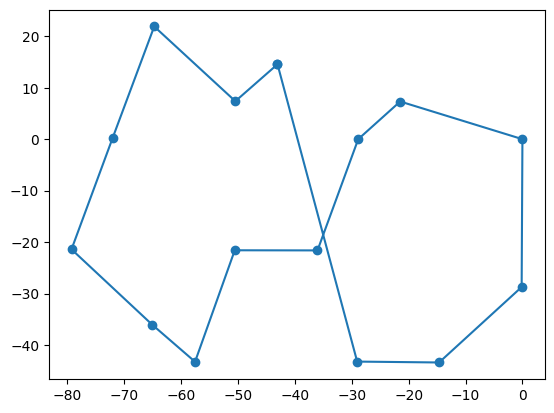

1. cost --> 304.9881303549301


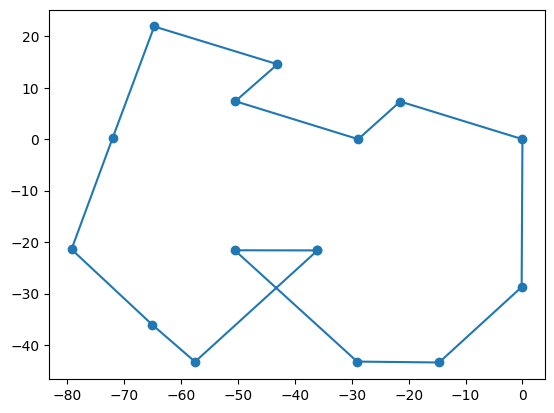

2. cost --> 284.3810904080332


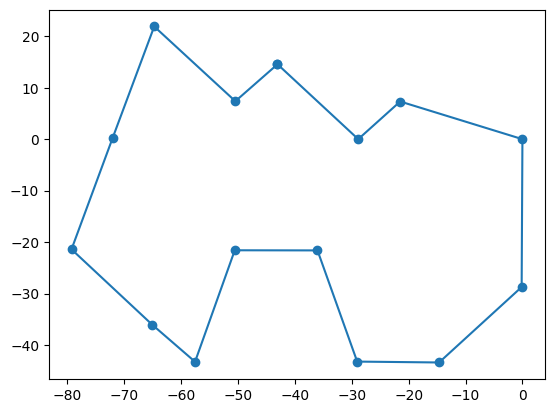

3. cost --> 289.40917445687427


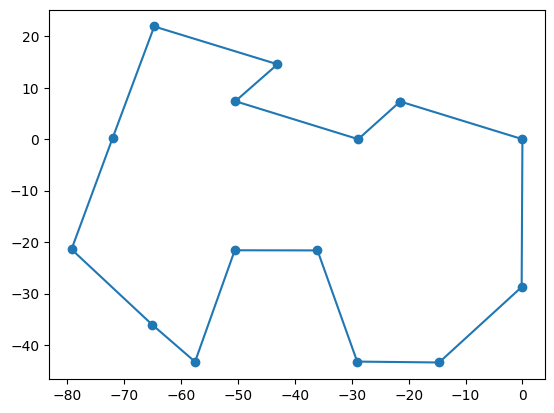

4. cost --> 289.40917445687427


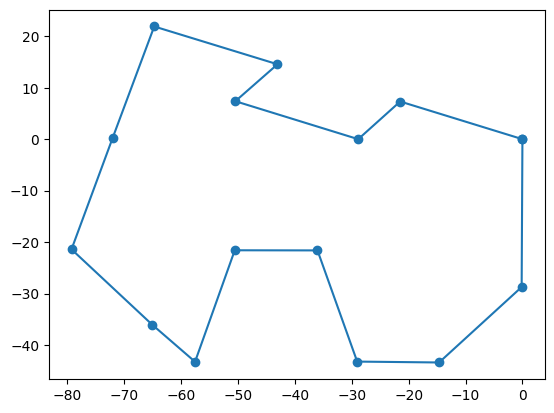

5. cost --> 289.40917445687427


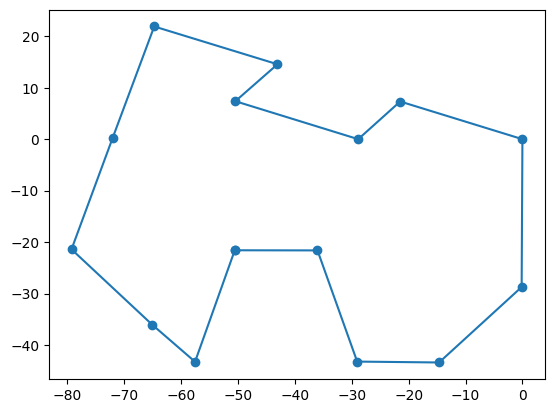

6. cost --> 292.50579675888645


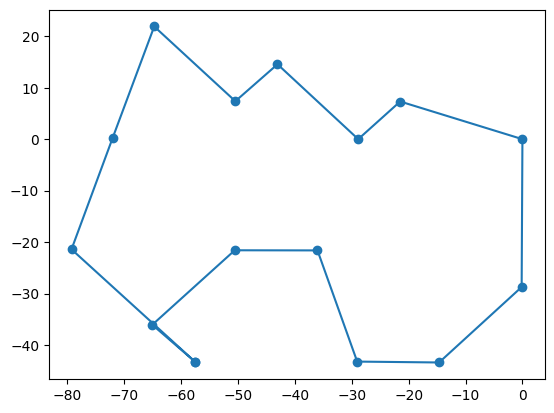

7. cost --> 284.3810904080331


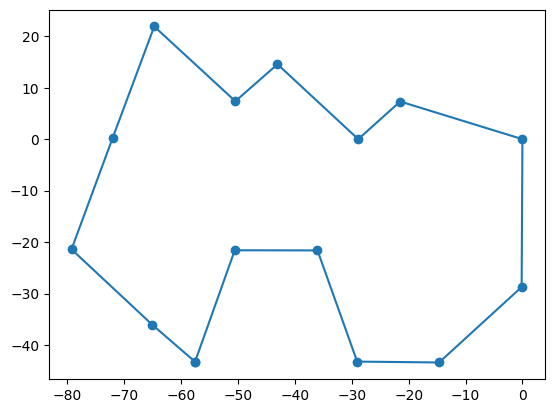

8. cost --> 284.3810904080332


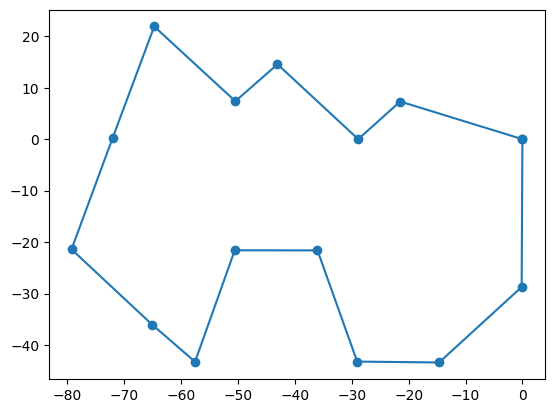

9. cost --> 284.3810904080332


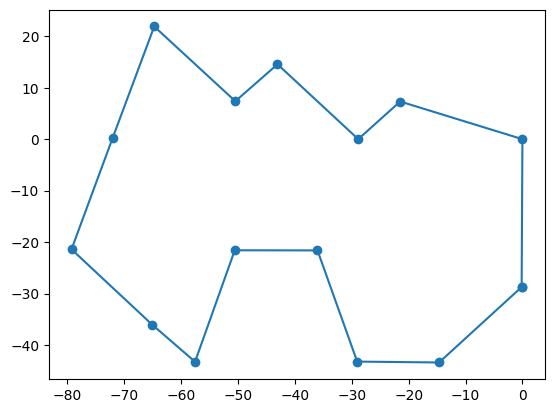

10. cost --> 289.40917445687427


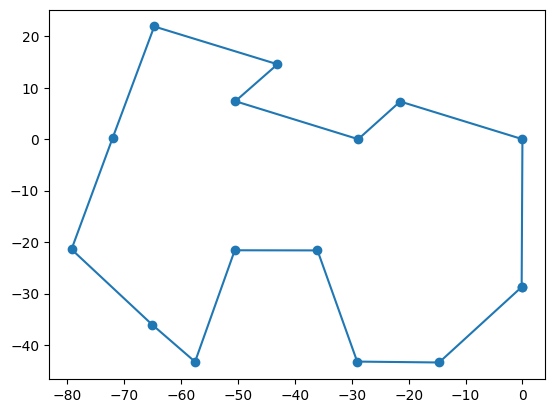

11. cost --> 284.3810904080332


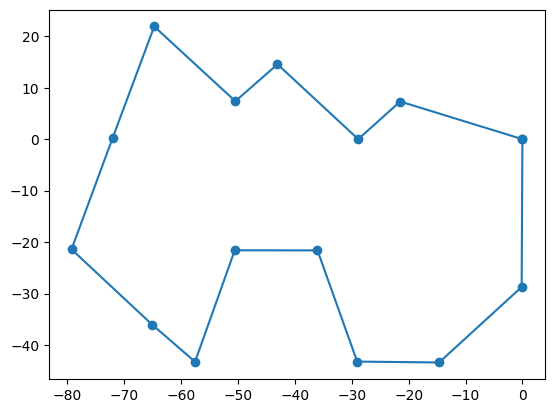

12. cost --> 284.3810904080332


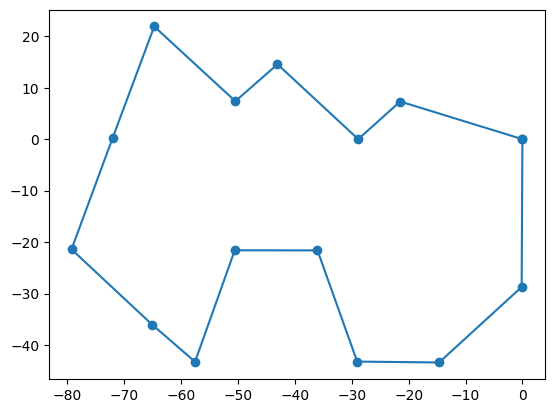

13. cost --> 284.3810904080332


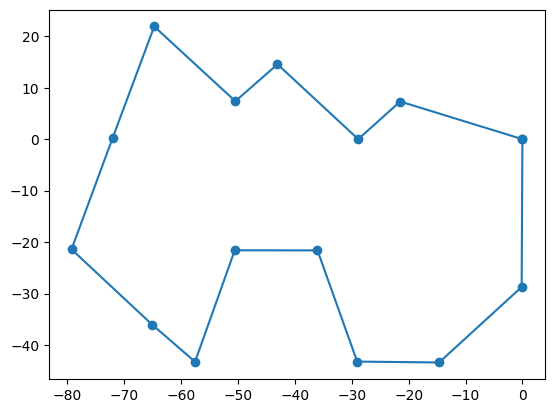

14. cost --> 284.3810904080332


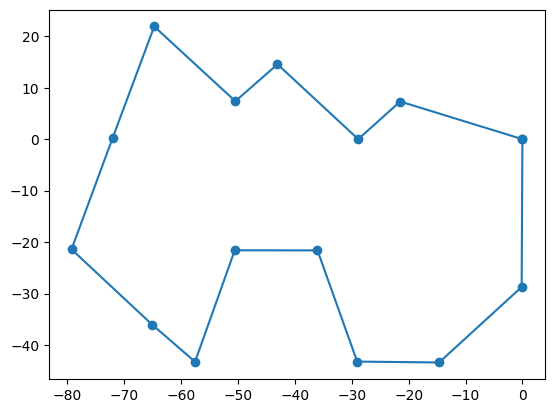

15. cost --> 284.3810904080332


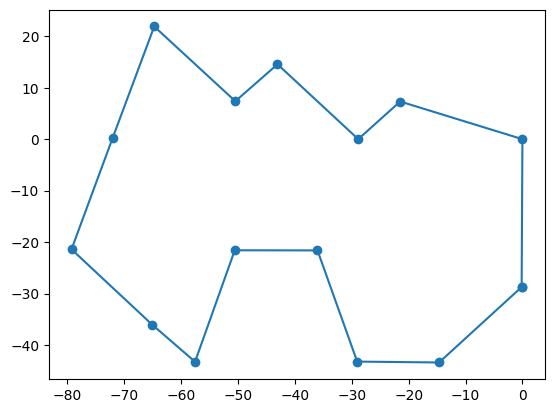

16. cost --> 284.3810904080332


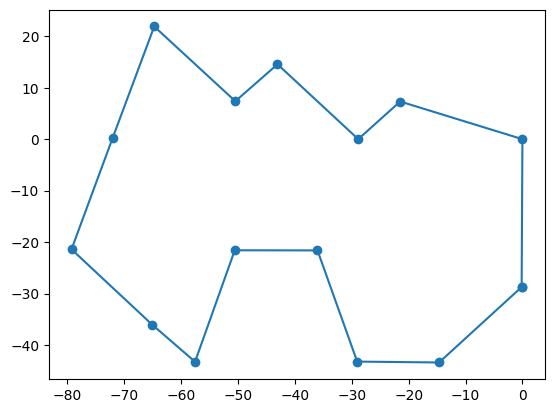

17. cost --> 284.3810904080332


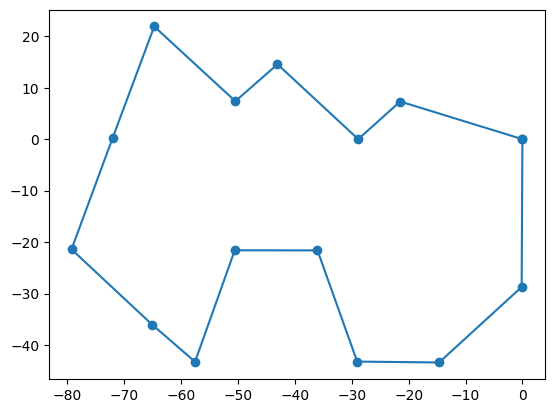

18. cost --> 284.3810904080332


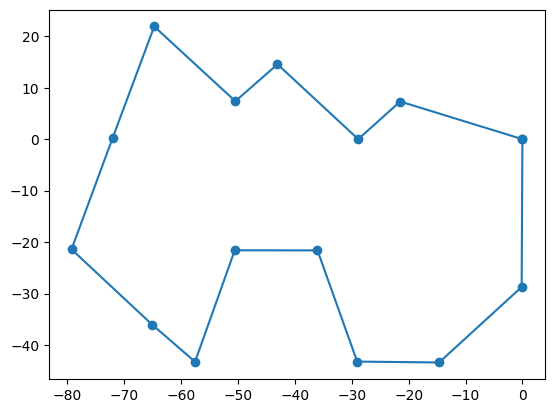

19. cost --> 284.3810904080332


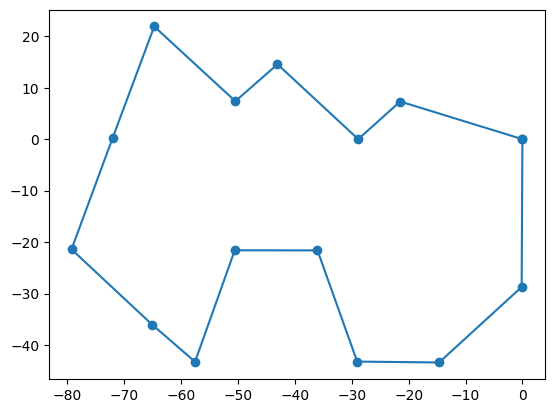

In [504]:
for i in range(num_iterations):
  paths = []
  path_costs = []
  best_path = None
  best_path_cost = np.inf

  for j in range(num_ants):
    #constructions
    ant=Ant(path_construction(all_cities,pheromones_matrix,distance_matrix))
    ant.cost=ant.calculate_cost(distance_matrix)
    ant.fitness=ant.calculate_fitness()

    paths.append(ant.path)
    path_costs.append(ant.cost)

    if ant.cost < best_path_cost:
        best_path = ant.path
        best_path_cost = ant.cost

  print(str(i) + ". cost --> " + str(best_path_cost+distance_matrix[int(best_path[0].name)-1,int(best_path[-1].name)-1]))
  # Plot the best solution path for visualization
  draw_path(best_path)

  #updating
  pheromones_matrix *= evaporation_rate

  for path, path_length in zip(paths, path_costs):
      for i in range(len(all_cities)-1):
          pheromones_matrix[int(path[i].name)-1, int(path[i+1].name)-1] += 1/path_length
      pheromones_matrix[int(path[-1].name)-1, int(path[0].name)-1] += 1/path_length


